In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.metrics import mean_squared_error

In [3]:
test1_df = pd.read_csv('SE_rents2018_test1.csv', index_col=0)
test2_df = pd.read_csv('SE_rents2018_test2.csv', index_col=0)
test3_df = pd.read_csv('SE_rents2018_test3.csv', index_col=0)
train_df = pd.read_csv('SE_rents2018_train.csv', index_col=0)
# bedrooms, bathrooms, size_sqft, and year_built use for linear model.
# borough, neighborhood, has_doorman, and size_sqft for non-linear model. 

In [34]:
url = 'https://api.census.gov/data/2017/acs/acs5?'
params = {'get' : 'NAME,B19013_001E,B25058_001E',
          'for' : 'zip code tabulation area:*',}

r = requests.get(url, params=params)
print(r.url)

https://api.census.gov/data/2017/acs/acs5?get=NAME%2CB19013_001E%2CB25058_001E&for=zip+code+tabulation+area%3A%2A


In [35]:
income_df = pd.DataFrame(r.json()[1:], columns=r.json()[0])
income_df.head(10)

,NAME,B19013_001E,B25058_001E,zip code tabulation area
0,ZCTA5 00601,11757,291,00601
1,ZCTA5 00602,16190,304,00602
2,ZCTA5 00603,16645,306,00603
3,ZCTA5 00606,13387,185,00606
4,ZCTA5 00610,18741,322,00610
5,ZCTA5 00612,17744,310,00612
6,ZCTA5 00616,14918,327,00616
7,ZCTA5 00617,17157,375,00617
8,ZCTA5 00622,16727,392,00622
9,ZCTA5 00623,16401,352,00623


In [44]:

income_df = (income_df
             .rename(
                 columns={
                          'B19013_001E' : 'Median Household Income',
                          'B25058_001E' : 'Median Rent',
                          'zip code tabulation area' : 'addr_zip',
                         }
             )
            )
income_df.head(3)
#income_df.loc['10956']
#income_df.dtypes

,NAME,Median Household Income,Median Rent,addr_zip
0,ZCTA5 00601,11757,291,00601
1,ZCTA5 00602,16190,304,00602
2,ZCTA5 00603,16645,306,00603


In [48]:
income_df['addr_zip'] = income_df['addr_zip'].astype(int)

In [31]:
test1_df.head(5)

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,...,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
rental_id,,,,,,,,,,,,,,,,,,,,,
7499437,#1B,18724,1,1.0,550.0,2018-08-22 10:00:37,167 MOTT STREET,New York,10013,40.719799,...,0,0,2700,1,"By Owner, No Fees!\n\nNewly renovated building...",Little Italy,Manhattan,1B,1.0,B
7477903,#C4,403900,1,1.0,750.0,2018-08-15 11:41:23,107 LINDEN STREET,Brooklyn,11221,40.693118,...,0,0,1650,1,this is a beautiful spacious renovated full s...,Bushwick,Brooklyn,C4,4.0,C
7481023,#GARDEN,18175264,2,1.0,800.0,2018-08-15 22:20:14,47 CARROLL STREET,Brooklyn,11231,40.683399,...,1,0,2900,0,"Garden level, pet-friendly, 2 bedroom, 1 bath ...",Columbia St Waterfront District,Brooklyn,GARDEN,NaN,NaN
7479547,#2C,104863,2,2.0,1300.0,2018-08-15 16:05:22,952 COLUMBUS AVENUE,New York,10025,40.799900,...,0,0,4750,1,Ivy Park is a boutique condominium with a uniq...,Upper West Side,Manhattan,2C,2.0,C
7518814,#9,95125,2,1.0,750.0,2018-08-29 12:00:12,424 EAST 116 STREET,New York,10029,40.795350,...,0,0,1800,0,Located across from the New East River Plaza w...,East Harlem,Manhattan,9,NaN,NaN


In [59]:
#TODO I got stuck here
test1_df.merge(right=income_df,how='left', on='addr_zip')
test1_df.shape

(2000, 38)

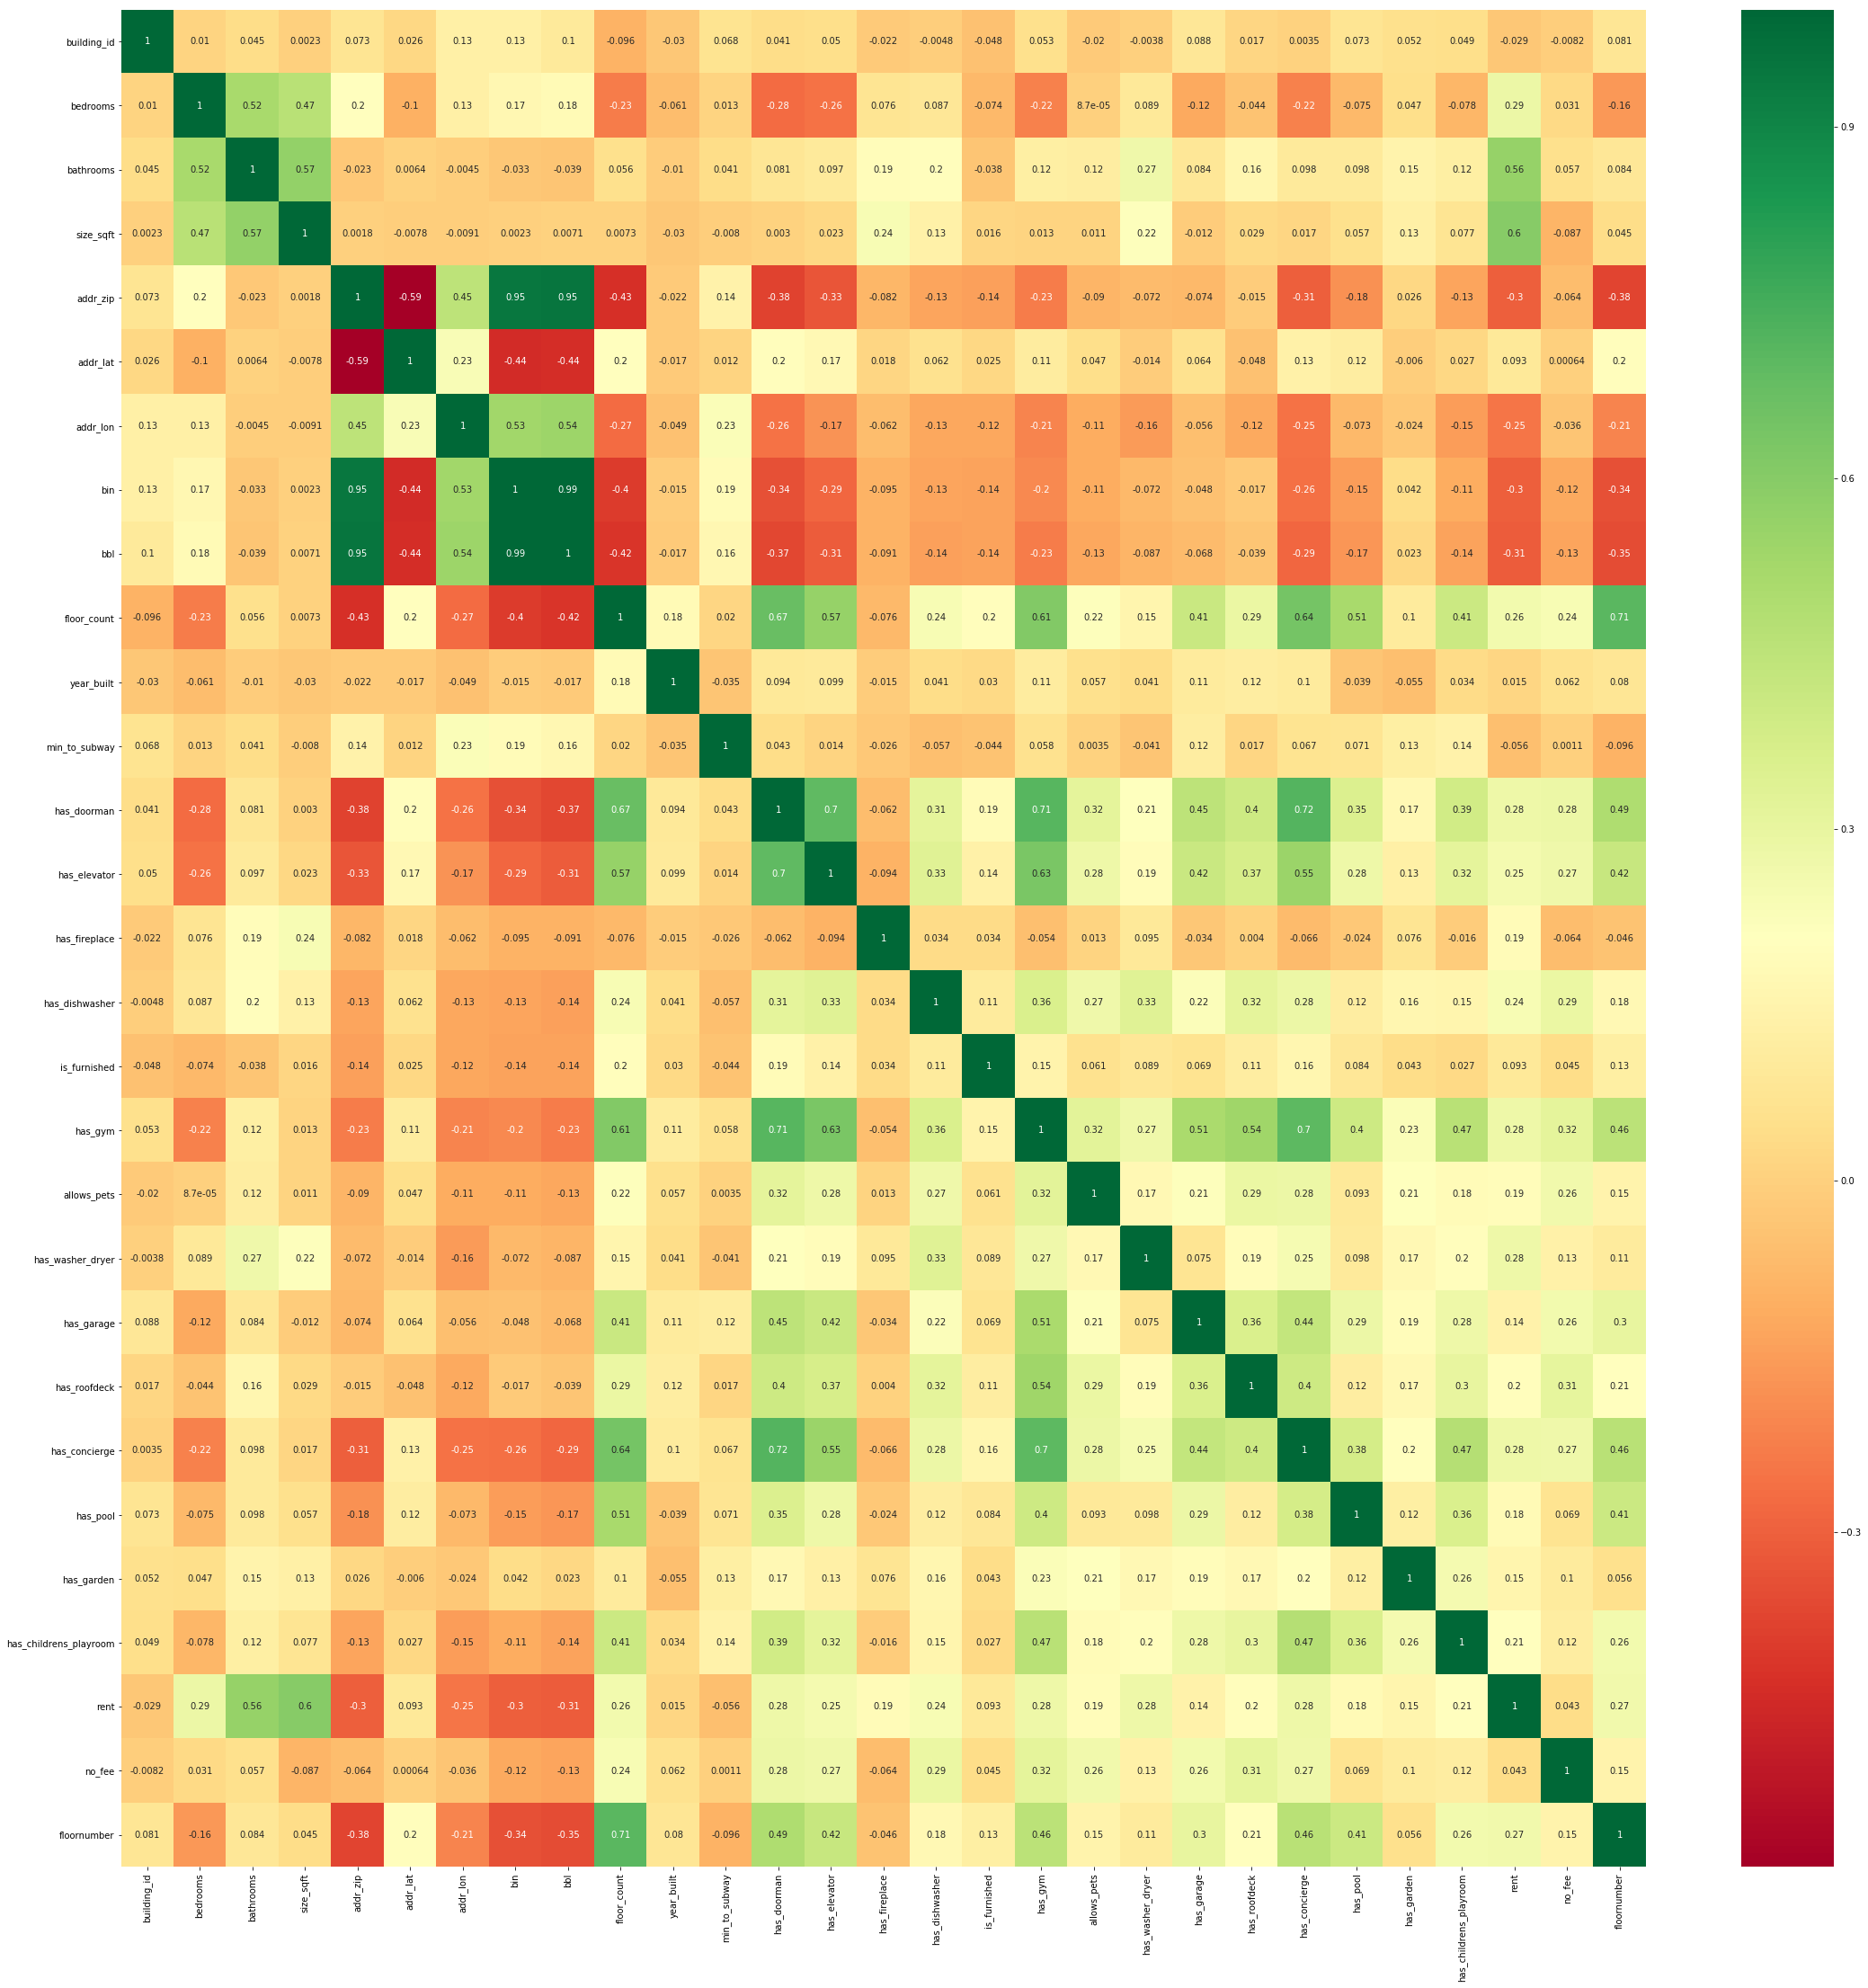

In [50]:
#using a heatmap to select meaningful features
#columns = test1_df[:,0:29]
#target = test1_df.rent
corrmat = test1_df.corr()
test1_top_corr = corrmat.index
plt.figure(figsize=(38,38))
test1_g = sns.heatmap(test1_df[test1_top_corr].corr(), annot=True, cmap="RdYlGn")

C:\Users\Jonathan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


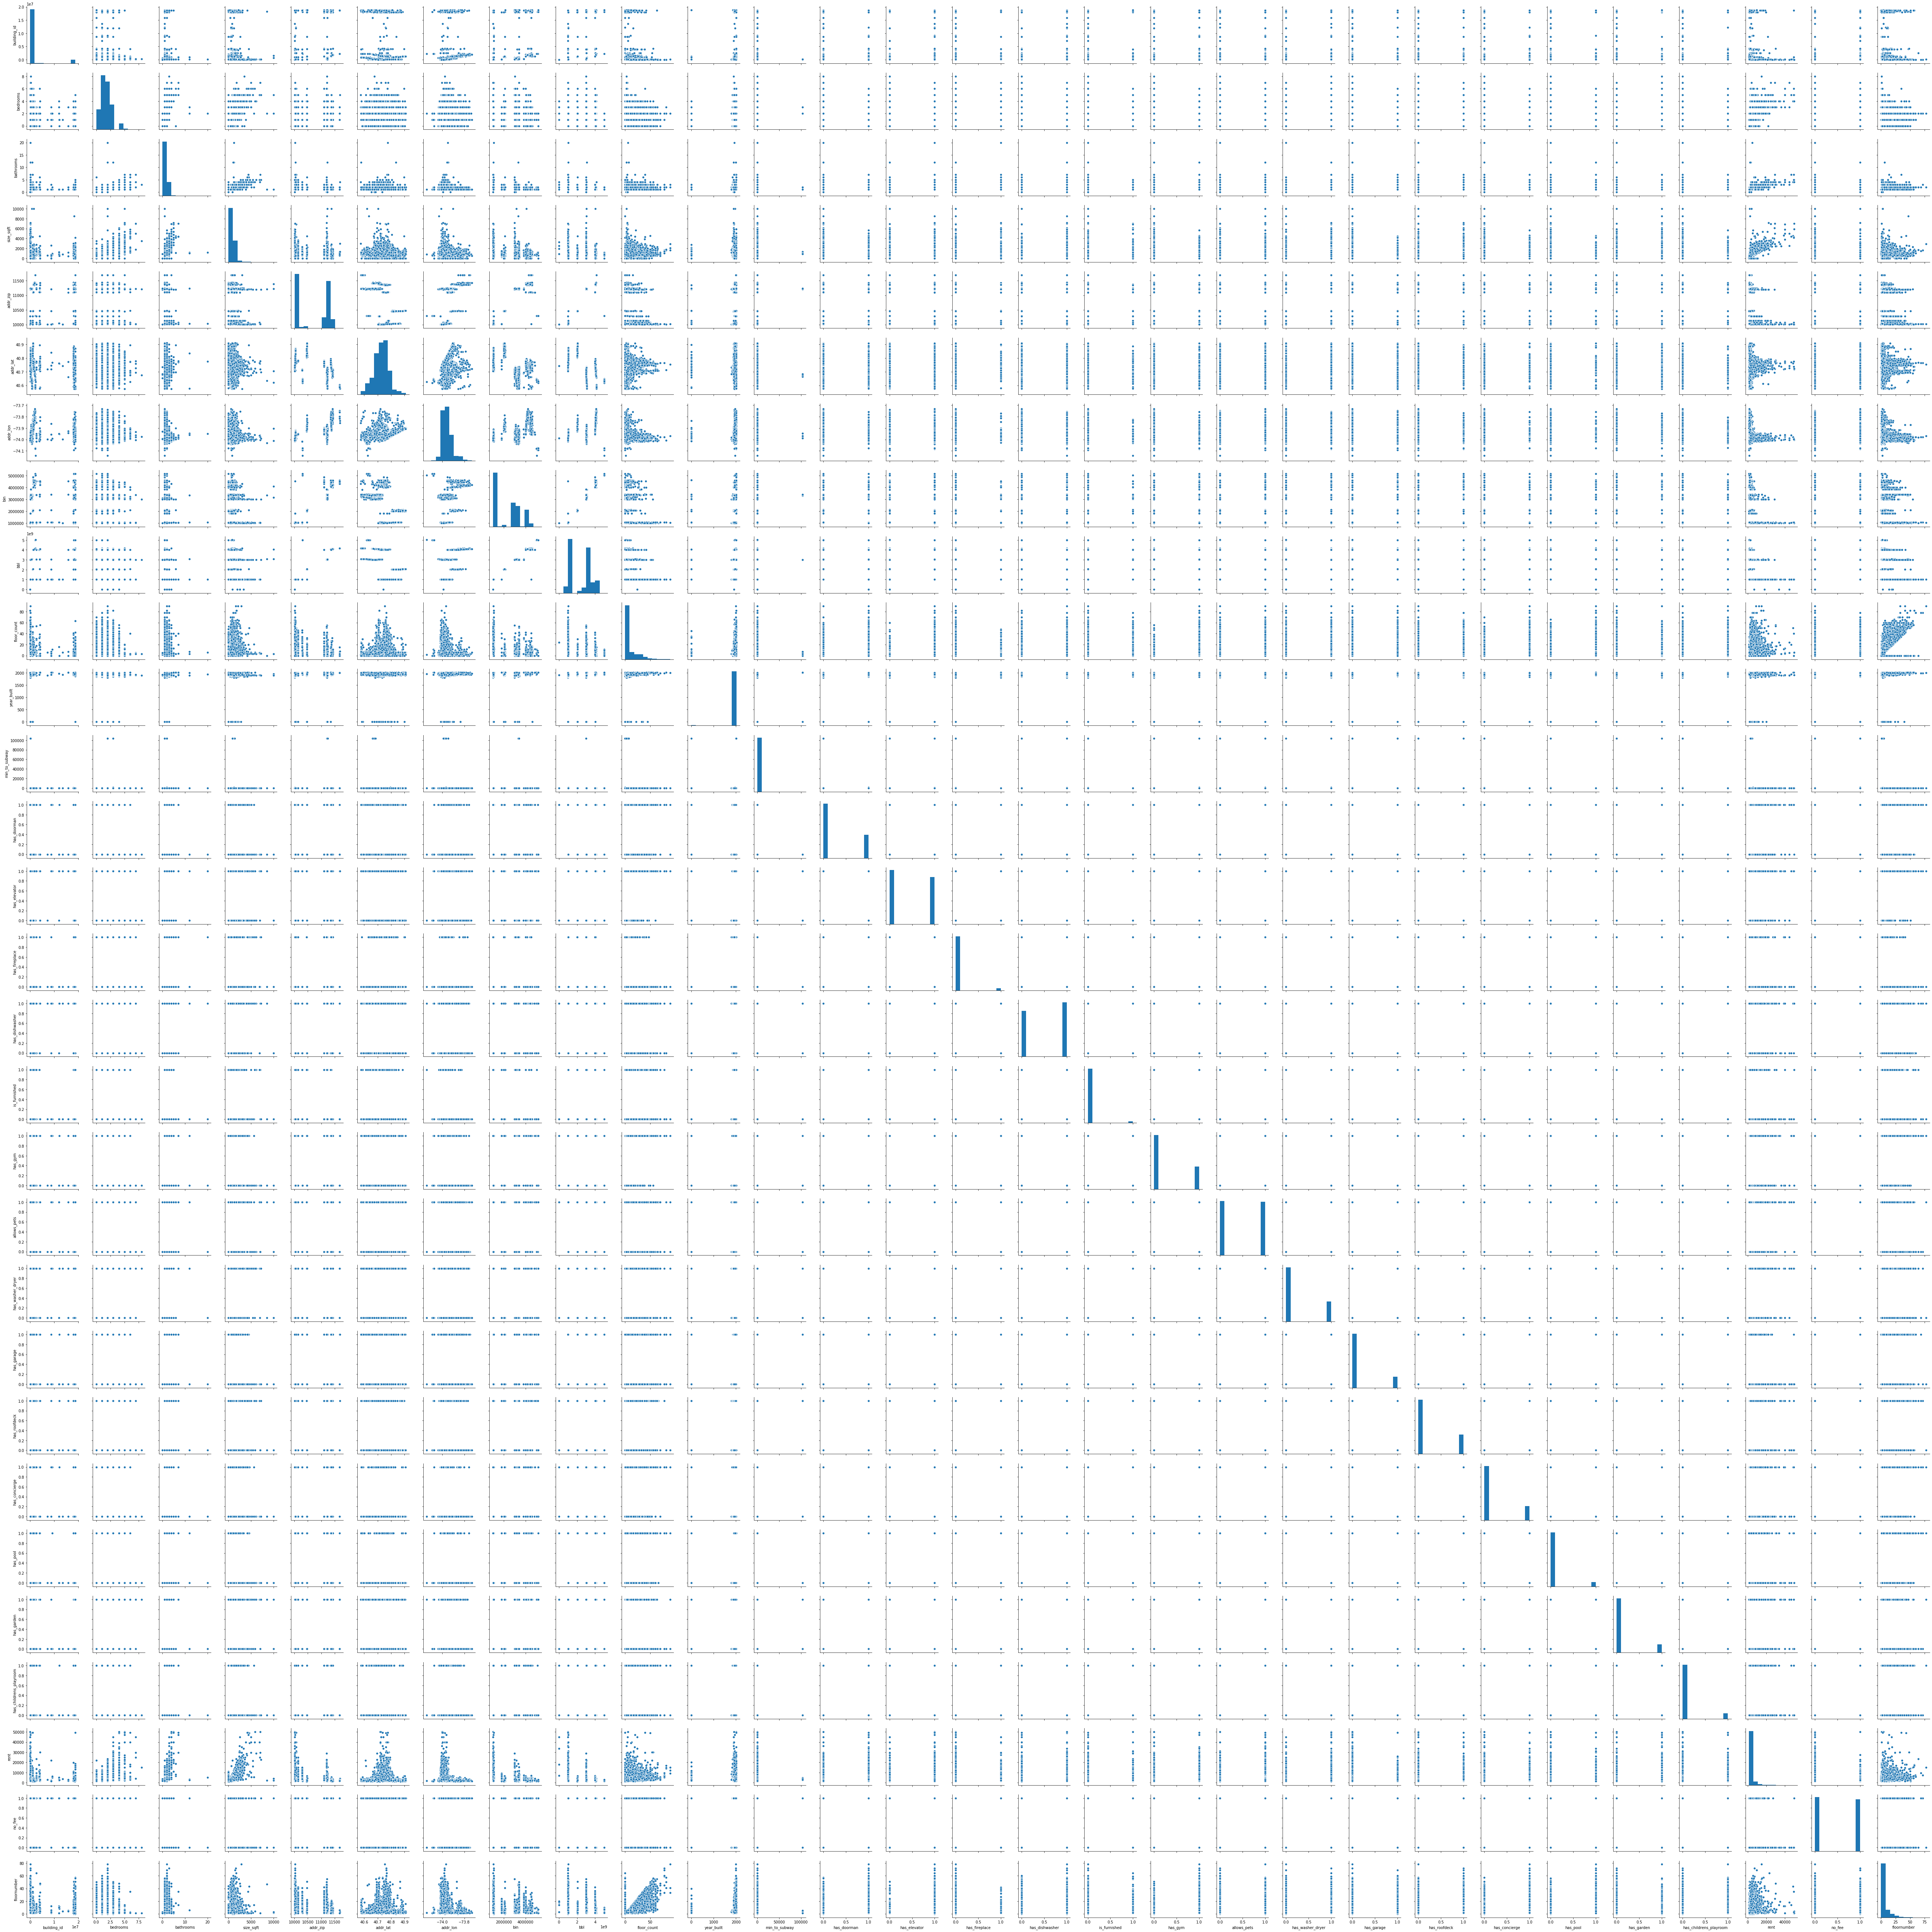

In [4]:
sns.pairplot(train_df, size=2.5)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_linear_reg_model(X_train, y_train, X_test, y_test):
    """Trains and test linear regression model and returns mean_squared_error of
    y_test and y_predicted. 
    ----------
    X_train : data frame, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_train : data frame, shape = [n_samples]
        n_sample target values.
        
    X_test : data frame, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_test : data frame, shape = [n_samples]
        n_sample target values.
        
    Return 
        (data frame) y_prediction: predictions made from X_test
        (float) mean_squared_error of (y_test and y_prediction)
        (LinearRegression) returns the linear regression model.
    """

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_prediction = lr.predict(X_test)
    
    return lr ,y_prediction, mean_squared_error(y_test, y_prediction)

In [0]:
columns_needed = ['bathrooms', 'size_sqft', 'bin','bbl','has_doorman','floor_count','has_gym','rent']
features = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym']

linear_reg_train_df = train_df[columns_needed]

# Dataset contains one null value in bin. So I decided to drop it.
linear_reg_train_df = linear_reg_train_df.dropna(axis=0)

# Getting the features for training.
train_dropped_na = linear_reg_train_df[features]
# Getting the target columns
train_dropped_na_target = linear_reg_train_df[['rent']]

# Extracting the columns needed for testing. Useing test1.csv file.
test1_lr_df = test1_df[features]
# Getting the target columns to get accuracy of predictions. 
test1_lr_target = test1_df[['rent']]

lr, y_prediction, mse = train_linear_reg_model(train_dropped_na, train_dropped_na_target, test1_lr_df, test1_lr_target)
print("Mean square error of test1: " + str(mse))

In [54]:
test2_lr_df = test2_df[features]
test2_rent_predictions = lr.predict(test2_lr_df)
test2_rent_predictions = pd.DataFrame(test2_rent_predictions, index=test2_lr_df.index, columns=['rent'])
test2_rent_predictions
# send to a csv file
test2_rent_predictions.to_csv('rent_predictions.csv')
